In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

import AnomalyCLIP_lib
import torch
import argparse
import torch.nn.functional as F
from prompt_ensemble import AnomalyCLIP_PromptLearner
from dataset import Dataset
from logger import get_logger
from tqdm import tqdm
from sklearn.metrics import  precision_score, recall_score

import random
# from tabulate import tabulate
from utils import get_transform

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


from tqdm import tqdm
from scipy.ndimage import gaussian_filter

In [6]:
parser = argparse.ArgumentParser("AnomalyCLIP", add_help=True)
# paths
parser.add_argument("--data_path", type=str, default="./data/orange", help="path to test dataset")
parser.add_argument("--save_path", type=str, default='./results/CP/orange_outlier', help='path to save results')
parser.add_argument("--checkpoint_path", type=str, default='./train_results/0819_orange/epoch_15.pth', help='path to checkpoint')
# model
parser.add_argument("--dataset", type=str, default='orange')
parser.add_argument("--features_list", type=int, nargs="+", default=[6, 12, 18, 24], help="features used")
parser.add_argument("--image_size", type=int, default=518, help="image size")
parser.add_argument("--depth", type=int, default=9, help="image size")
parser.add_argument("--n_ctx", type=int, default=12, help="zero shot")
parser.add_argument("--t_n_ctx", type=int, default=4, help="zero shot")
parser.add_argument("--feature_map_layer", type=int,  nargs="+", default=[0, 1, 2, 3], help="zero shot")
parser.add_argument("--metrics", type=str, default='image-pixel-level')
parser.add_argument("--seed", type=int, default=111, help="random seed")
parser.add_argument("--sigma", type=int, default=4, help="zero shot")

args = parser.parse_args(args=[])

In [4]:
logger = get_logger(args.save_path)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'device ===> {device}')

device ===> cuda


# Train data

In [7]:
AnomalyCLIP_parameters = {"Prompt_length": args.n_ctx, "learnabel_text_embedding_depth": args.depth, "learnabel_text_embedding_length": args.t_n_ctx}
model, _ = AnomalyCLIP_lib.load("ViT-L/14@336px", device=device, design_details = AnomalyCLIP_parameters)
model.eval()

preprocess, target_transform = get_transform(args)
train_data = Dataset(root=args.data_path, transform=preprocess, target_transform=target_transform, dataset_name = args.dataset, mode='train')
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False)
obj_list = train_data.obj_list
print(f'obj_list ===> {obj_list}\n')

train_results = {}
train_metrics = {}
for obj in obj_list:
    train_results[obj] = {}
    train_results[obj]['gt_sp'] = []
    train_results[obj]['pr_sp'] = []
    train_results[obj]['pr_sp_n'] = []
    train_results[obj]['imgs_masks'] = []
    train_results[obj]['anomaly_maps'] = []
    train_metrics[obj] = {}
    train_metrics[obj]['pixel-auroc'] = 0
    train_metrics[obj]['pixel-aupro'] = 0
    train_metrics[obj]['image-auroc'] = 0
    train_metrics[obj]['image-ap'] = 0

prompt_learner = AnomalyCLIP_PromptLearner(model.to("cpu"), AnomalyCLIP_parameters)
checkpoint = torch.load(args.checkpoint_path)
prompt_learner.load_state_dict(checkpoint["prompt_learner"])
prompt_learner.to(device)
model.to(device)
model.visual.DAPM_replace(DPAM_layer = 20)

prompts, tokenized_prompts, compound_prompts_text = prompt_learner(cls_id = None)

text_features = model.encode_text_learn(prompts, tokenized_prompts, compound_prompts_text).float()
text_features = torch.stack(torch.chunk(text_features, dim = 0, chunks = 2), dim = 1)
text_features = text_features/text_features.norm(dim=-1, keepdim=True)
# print(text_features)

model.to(device)
features_list = args.features_list

for idx, items in enumerate(tqdm(train_dataloader)):
    
    image = items['img'].to(device)
    cls_name = items['cls_name']
    cls_id = items['cls_id']
    gt_mask = items['img_mask']
    gt_mask[gt_mask > 0.5], gt_mask[gt_mask <= 0.5] = 1, 0
    train_results[cls_name[0]]['imgs_masks'].append(gt_mask)  # px
    train_results[cls_name[0]]['gt_sp'].extend(items['anomaly'].detach().cpu())

    with torch.no_grad():
        image_features, patch_features = model.encode_image(image, features_list, DPAM_layer = 20)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        text_probs = image_features @ text_features.permute(0, 2, 1)
        text_probs = (text_probs/0.07).softmax(-1)
        text_probs_a = text_probs[:, 0, 1]
        text_probs_n = text_probs[:, 0, 0]
        anomaly_map_list = []
        for idx, patch_feature in enumerate(patch_features):
            if idx >= args.feature_map_layer[0]:
                patch_feature = patch_feature/ patch_feature.norm(dim = -1, keepdim = True)
                similarity, _ = AnomalyCLIP_lib.compute_similarity(patch_feature, text_features[0])
                similarity_map = AnomalyCLIP_lib.get_similarity_map(similarity[:, 1:, :], args.image_size)
                anomaly_map = (similarity_map[...,1] + 1 - similarity_map[...,0])/2.0
                anomaly_map_list.append(anomaly_map)

        anomaly_map = torch.stack(anomaly_map_list)
        
        anomaly_map = anomaly_map.sum(dim = 0)
        train_results[cls_name[0]]['pr_sp'].extend(text_probs_a.detach().cpu()) # image-abnormal
        train_results[cls_name[0]]['pr_sp_n'].extend(text_probs_n.detach().cpu()) # image-normal
        anomaly_map = torch.stack([torch.from_numpy(gaussian_filter(i, sigma = args.sigma)) for i in anomaly_map.detach().cpu()], dim = 0 )
        train_results[cls_name[0]]['anomaly_maps'].append(anomaly_map)

name ViT-L/14@336px
text_layer False
text_layer True
 
 ********************** train ********************** 

obj_list ===> ['orange']

embedding_pos torch.Size([1, 77, 768])
tokenized_prompts shape torch.Size([1, 1, 77]) torch.Size([1, 1, 77])


c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
100%|██████████| 30/30 [00:12<00:00,  2.45it/s]


# Test data

In [8]:
model, _ = AnomalyCLIP_lib.load("ViT-L/14@336px", device=device, design_details = AnomalyCLIP_parameters)
model.eval()

preprocess, target_transform = get_transform(args)
test_data = Dataset(root=args.data_path, transform=preprocess, target_transform=target_transform, dataset_name = args.dataset)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)
obj_list = test_data.obj_list

test_results = {}
test_metrics = {}
for obj in obj_list:
    test_results[obj] = {}
    test_results[obj]['gt_sp'] = []
    test_results[obj]['pr_sp'] = []
    test_results[obj]['pr_sp_n'] = []
    test_results[obj]['imgs_masks'] = []
    test_results[obj]['anomaly_maps'] = []
    test_metrics[obj] = {}
    test_metrics[obj]['pixel-auroc'] = 0
    test_metrics[obj]['pixel-aupro'] = 0
    test_metrics[obj]['image-auroc'] = 0
    test_metrics[obj]['image-ap'] = 0

prompt_learner = AnomalyCLIP_PromptLearner(model.to("cpu"), AnomalyCLIP_parameters)
checkpoint = torch.load(args.checkpoint_path)
prompt_learner.load_state_dict(checkpoint["prompt_learner"])
prompt_learner.to(device)
model.to(device)
model.visual.DAPM_replace(DPAM_layer = 20)

prompts, tokenized_prompts, compound_prompts_text = prompt_learner(cls_id = None)

text_features = model.encode_text_learn(prompts, tokenized_prompts, compound_prompts_text).float()
text_features = torch.stack(torch.chunk(text_features, dim = 0, chunks = 2), dim = 1)
text_features = text_features/text_features.norm(dim=-1, keepdim=True)
# print(text_features)

model.to(device)
features_list = args.features_list

for idx, items in enumerate(tqdm(test_dataloader)):
    
    image = items['img'].to(device)
    cls_name = items['cls_name']
    cls_id = items['cls_id']
    gt_mask = items['img_mask']
    gt_mask[gt_mask > 0.5], gt_mask[gt_mask <= 0.5] = 1, 0
    test_results[cls_name[0]]['imgs_masks'].append(gt_mask)  # px
    test_results[cls_name[0]]['gt_sp'].extend(items['anomaly'].detach().cpu())

    with torch.no_grad():
        image_features, patch_features = model.encode_image(image, features_list, DPAM_layer = 20)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        text_probs = image_features @ text_features.permute(0, 2, 1)
        text_probs = (text_probs/0.07).softmax(-1)
        text_probs_a = text_probs[:, 0, 1]
        text_probs_n = text_probs[:, 0, 0]
        anomaly_map_list = []
        for idx, patch_feature in enumerate(patch_features):
            if idx >= args.feature_map_layer[0]:
                patch_feature = patch_feature/ patch_feature.norm(dim = -1, keepdim = True)
                similarity, _ = AnomalyCLIP_lib.compute_similarity(patch_feature, text_features[0])
                similarity_map = AnomalyCLIP_lib.get_similarity_map(similarity[:, 1:, :], args.image_size)
                anomaly_map = (similarity_map[...,1] + 1 - similarity_map[...,0])/2.0
                anomaly_map_list.append(anomaly_map)

        anomaly_map = torch.stack(anomaly_map_list)
        
        anomaly_map = anomaly_map.sum(dim = 0)
        test_results[cls_name[0]]['pr_sp'].extend(text_probs_a.detach().cpu()) # image-abnormal
        test_results[cls_name[0]]['pr_sp_n'].extend(text_probs_n.detach().cpu()) # image-normal
        anomaly_map = torch.stack([torch.from_numpy(gaussian_filter(i, sigma = args.sigma)) for i in anomaly_map.detach().cpu()], dim = 0 )
        test_results[cls_name[0]]['anomaly_maps'].append(anomaly_map)

name ViT-L/14@336px
text_layer False
text_layer True
 
 ********************** test ********************** 

embedding_pos torch.Size([1, 77, 768])
tokenized_prompts shape torch.Size([1, 1, 77]) torch.Size([1, 1, 77])


100%|██████████| 69/69 [00:37<00:00,  1.82it/s]


# 1. Train dataset 에서 q_hat 구하기

##### train 데이터에 abnormal 이 있는 경우

In [16]:
scores = []
y_true = []
y_score_list = []
for obj in obj_list:
    scores += (train_results[obj]['pr_sp'])
    y_true += (test_results[obj]['gt_sp'])
    y_score_list += (test_results[obj]['pr_sp'] )

print(len(scores), len(y_true), len(y_score_list), end='\n')


for obj in obj_list:
    n = len(scores)
    alpha = 0.1

    q_level = np.ceil((n+1)*(1-alpha))/n 
    train_qhat = np.quantile(scores, q_level, method='higher')

    y_true = np.array(y_true)
    y_score_list = np.array(y_score_list)
    y_scores = (y_score_list > train_qhat)

    p = precision_score(y_true, y_scores)
    r = recall_score(y_true, y_scores)

print(f'train_qhat: {train_qhat} \nprecision: {round(p, 4)} \nrecall: {round(r, 4)}')

30 69 69
train_qhat: 0.08466021716594696 
precision: 0.0 
recall: 0.0


c:\Users\dmkwo\anaconda3\envs\drct\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### train 데이터에 abnormal 이 없는 경우

In [17]:
s = []
for obj in obj_list:
    for t in train_results[obj]['gt_sp']:
        s.append(t.item())
s = np.array(s)
normal_idx = np.where(s==0)[0]
print(len(normal_idx))

12


In [18]:
scores = []
y_true = []
y_score_list = []

for obj in obj_list:
    scores += (train_results[obj]['pr_sp'])
    y_true += (test_results[obj]['gt_sp'])
    y_score_list += (test_results[obj]['pr_sp'] )
scores = np.array(scores)[normal_idx]
print(len(scores), len(y_true), len(y_score_list), end='\n')

alpha = 0.1
for obj in obj_list:
    n = len(scores)
    alpha = 0.1

    q_level = np.ceil((n+1)*(1-alpha))/n 
    train_qhat_wo_n = np.quantile(scores, q_level, method='higher')

    y_true = np.array(y_true)
    y_score_list = np.array(y_score_list)
    y_scores = (y_score_list > train_qhat_wo_n)

    p = precision_score(y_true, y_scores)
    r = recall_score(y_true, y_scores)

print(f'train_qhat: {train_qhat_wo_n} \nprecision: {round(p, 4)} \nrecall: {round(r, 4)}')

12 69 69
train_qhat: 0.010094668716192245 
precision: 0.9574 
recall: 0.9375


# 2. calibration (noraml)

In [19]:
y_true = []
y_score_list = []
for obj in obj_list:
    y_true += (test_results[obj]['gt_sp'])
    y_score_list += (test_results[obj]['pr_sp'] )

y_true_np = np.array([t.item() for t in y_true])
count = len(np.where(y_true_np == 0)[0])

y_all = sorted(list(zip(y_true, y_score_list)))

print(f'정상 개수 ===> {count} \n전체개수 ===> {len(y_all)} \n')

정상 개수 ===> 21 
전체개수 ===> 69 



In [21]:
normal_all_qhat = []
alpha = 0.1

for n in range(10, 16, 5):
    p_list = []
    r_list = []
    for i in range(count-n):
        score_list = np.array(y_all[i:i + n])[:, 1]
        
        y_pred_list = np.array(y_all[:i] + y_all[i + n:])[:, 1]
        y_label = np.array(y_all[:i] + y_all[i + n:])[:, 0]

        q_level = np.ceil((n+1)*(1-alpha))/n 
        qhat = np.quantile(score_list, q_level, method='higher')
        normal_all_qhat.append(qhat)
        
        y_pred = y_pred_list > qhat
        p = precision_score(y_label, y_pred)
        p_list.append(p)


        r = recall_score(y_label, y_pred)
        r_list.append(r)
    print(f'---{n}---')
    # print(f'score_list\n{len(score_list)}\n')
    print('q_hat 개수', len(normal_all_qhat))
    print('p_list', len(p_list))
    # print('y_true', len(y_true))
    print(f'precision: {round(sum(p_list)/len(p_list), 4)} \nrecall: {round(sum(r_list)/len(r_list), 4)}\n\n')

---10---
q_hat 개수 11
p_list 11
precision: 0.8898 
recall: 0.9735


---15---
q_hat 개수 17
p_list 6
precision: 0.9315 
recall: 0.9688




# 3. calibration (all)

In [22]:
y_true = []
y_score_list = []
for obj in obj_list:
    y_true += (test_results[obj]['gt_sp'])
    y_score_list += (test_results[obj]['pr_sp'] )

y_true_np = np.array([t.item() for t in y_true])
count = len(np.where(y_true_np == 0)[0])

y_all = list(zip(y_true, y_score_list))

print(f'정상 개수 ===> {count} \n전체개수 ===> {len(y_all)} \n')

정상 개수 ===> 21 
전체개수 ===> 69 



In [23]:
all_all_qhat = []
alpha = 0.1

for n in range(10, 16, 5):
    p_list = []
    r_list = []
    for i in range(len(y_all)-n):
        score_list = np.array(y_all[i:i + n])[:, 1]
        
        y_pred_list = np.array(y_all[:i] + y_all[i + n:])[:, 1]
        y_label = np.array(y_all[:i] + y_all[i + n:])[:, 0]

        q_level = np.ceil((n+1)*(1-alpha))/n 
        qhat = np.quantile(score_list, q_level, method='higher')
        all_all_qhat.append(qhat)
        
        y_pred = y_pred_list > qhat
        p = precision_score(y_label, y_pred, zero_division=0)
        p_list.append(p)


        r = recall_score(y_label, y_pred, zero_division=0)
        r_list.append(r)
    print(f'---{n}---')
    # print(f'score_list\n{len(score_list)}\n')
    print('q_hat 개수', len(all_all_qhat))
    # print('p_list', len(p_list))
    # print('y_true', len(y_true))
    print(f'precision: {round(sum(p_list)/len(p_list), 4)} \nrecall: {round(sum(r_list)/len(r_list), 4)}\n\n')

---10---
q_hat 개수 59
precision: 0.8637 
recall: 0.2349


---15---
q_hat 개수 113
precision: 0.8519 
recall: 0.1687




# 4. Plot

##### (1) Score

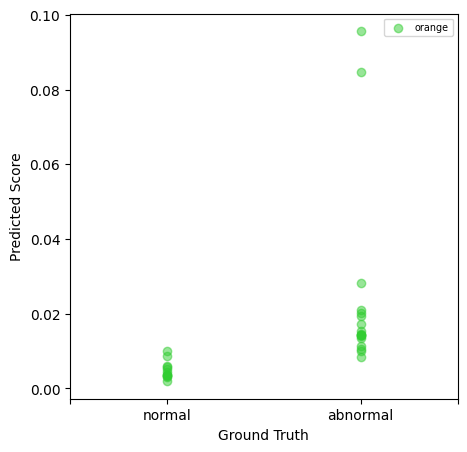

In [24]:
# train
color_list = ['limegreen', 'blueviolet', 'orange', 'lightsteelblue']
plt.figure(figsize=(5, 5))
for idx, obj in enumerate(obj_list):
    plt.scatter(train_results[obj]['gt_sp'], train_results[obj]['pr_sp'], color=color_list[idx], label=obj, alpha=0.5)
plt.legend(fontsize='x-small', bbox_to_anchor=(1.0, 1.0))
plt.xlabel('Ground Truth')
plt.ylabel('Predicted Score')
plt.xticks([-0.5, 0, 1, 1.5], labels=['', 'normal', 'abnormal', ''])
plt.show()

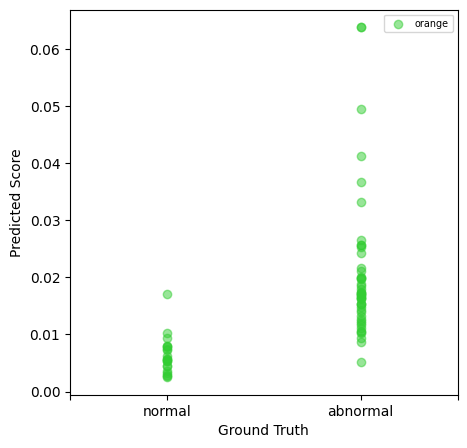

In [25]:
# test 
color_list = ['limegreen', 'blueviolet', 'orange', 'lightsteelblue']
plt.figure(figsize=(5, 5))
for idx, obj in enumerate(obj_list):
    plt.scatter(test_results[obj]['gt_sp'], test_results[obj]['pr_sp'], color=color_list[idx], label=obj, alpha=0.5)
plt.legend(fontsize='x-small', bbox_to_anchor=(1.0, 1.0))
plt.xlabel('Ground Truth')
plt.ylabel('Predicted Score')
plt.xticks([-0.5, 0, 1, 1.5], labels=['', 'normal', 'abnormal', ''])
plt.show()

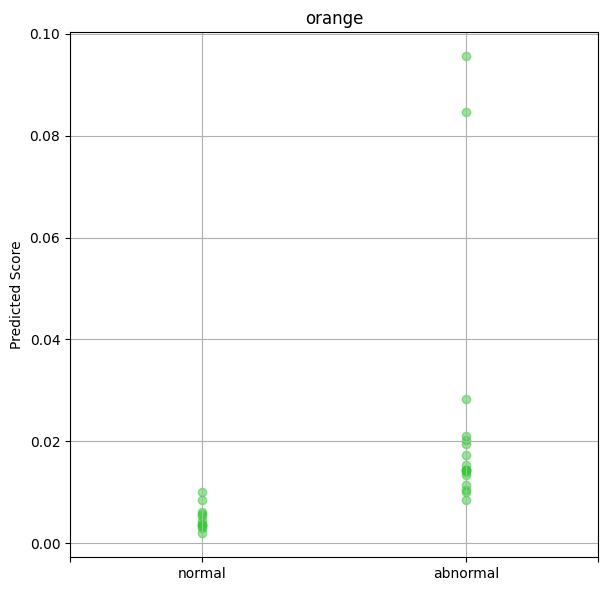

In [26]:
# train
plt.figure(figsize=(15, 15))

for idx, obj in enumerate(obj_list):
    
    plt.subplot(2, 2, idx+1)

    plt.scatter(train_results[obj]['gt_sp'], train_results[obj]['pr_sp'], color=color_list[idx], label=obj, alpha=0.5)
    plt.title(obj)
    plt.ylabel('Predicted Score')
    plt.grid()
    plt.xticks([-0.5, 0, 1, 1.5], labels=['', 'normal', 'abnormal', ''])
# plt.suptitle("Train set socre scatter plot (per class)")
plt.show()

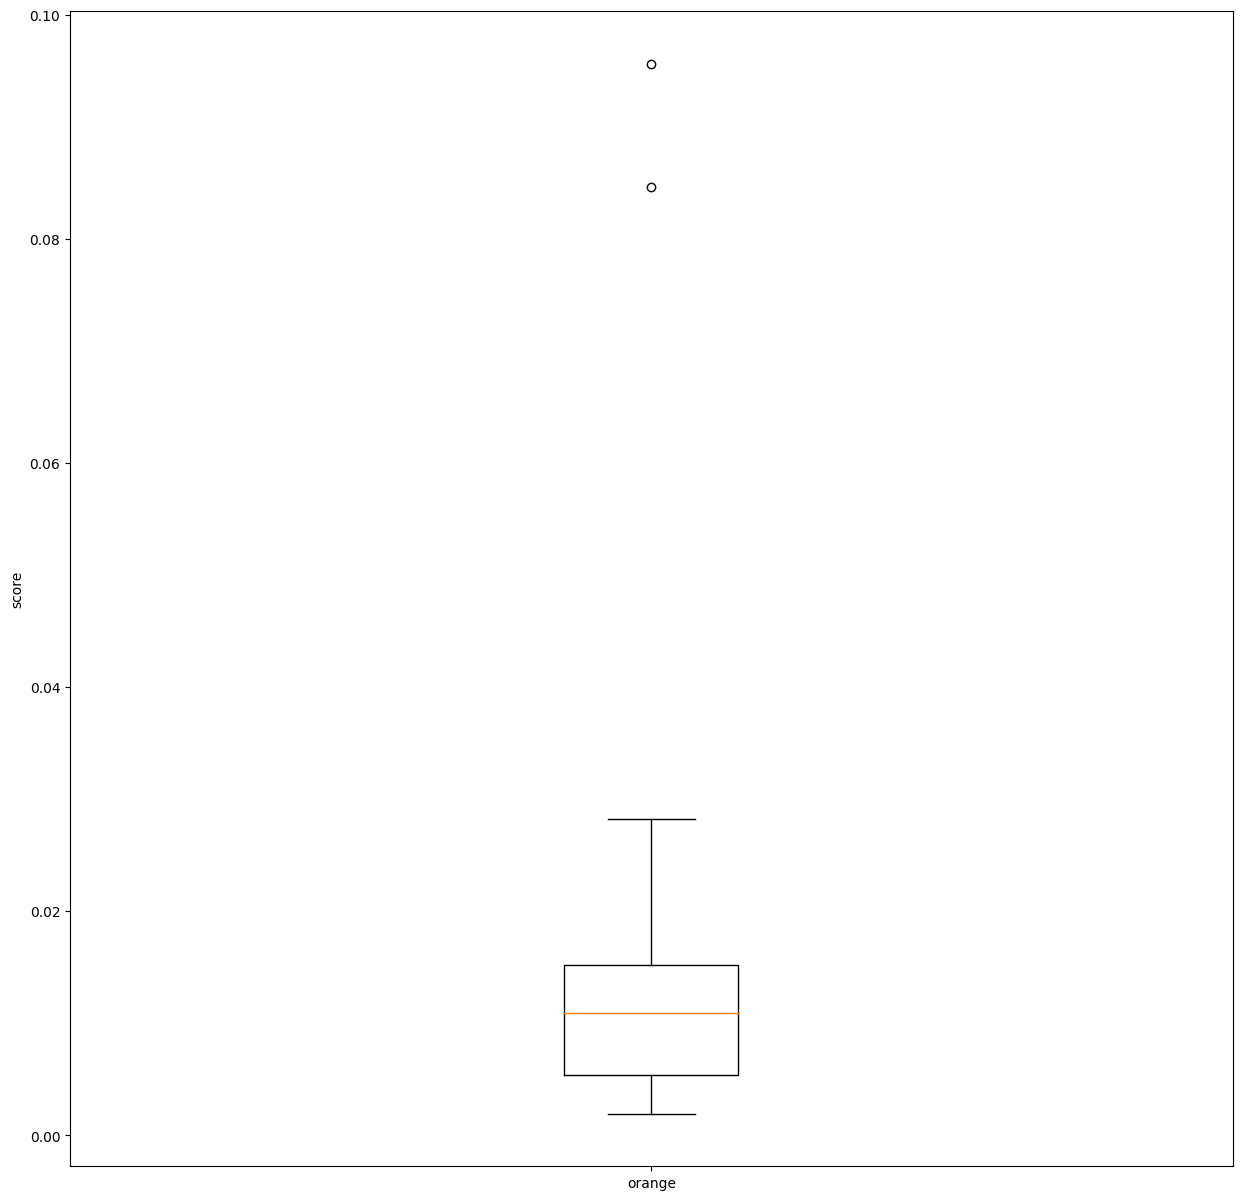

In [27]:
# train
plt.figure(figsize=(15, 15))
plt.boxplot([train_results[obj]['pr_sp'] for obj in obj_list])
plt.xticks([1], obj_list)
plt.ylabel('score')
# plt.title("Train set score box plot", fontsize=20)
plt.show()

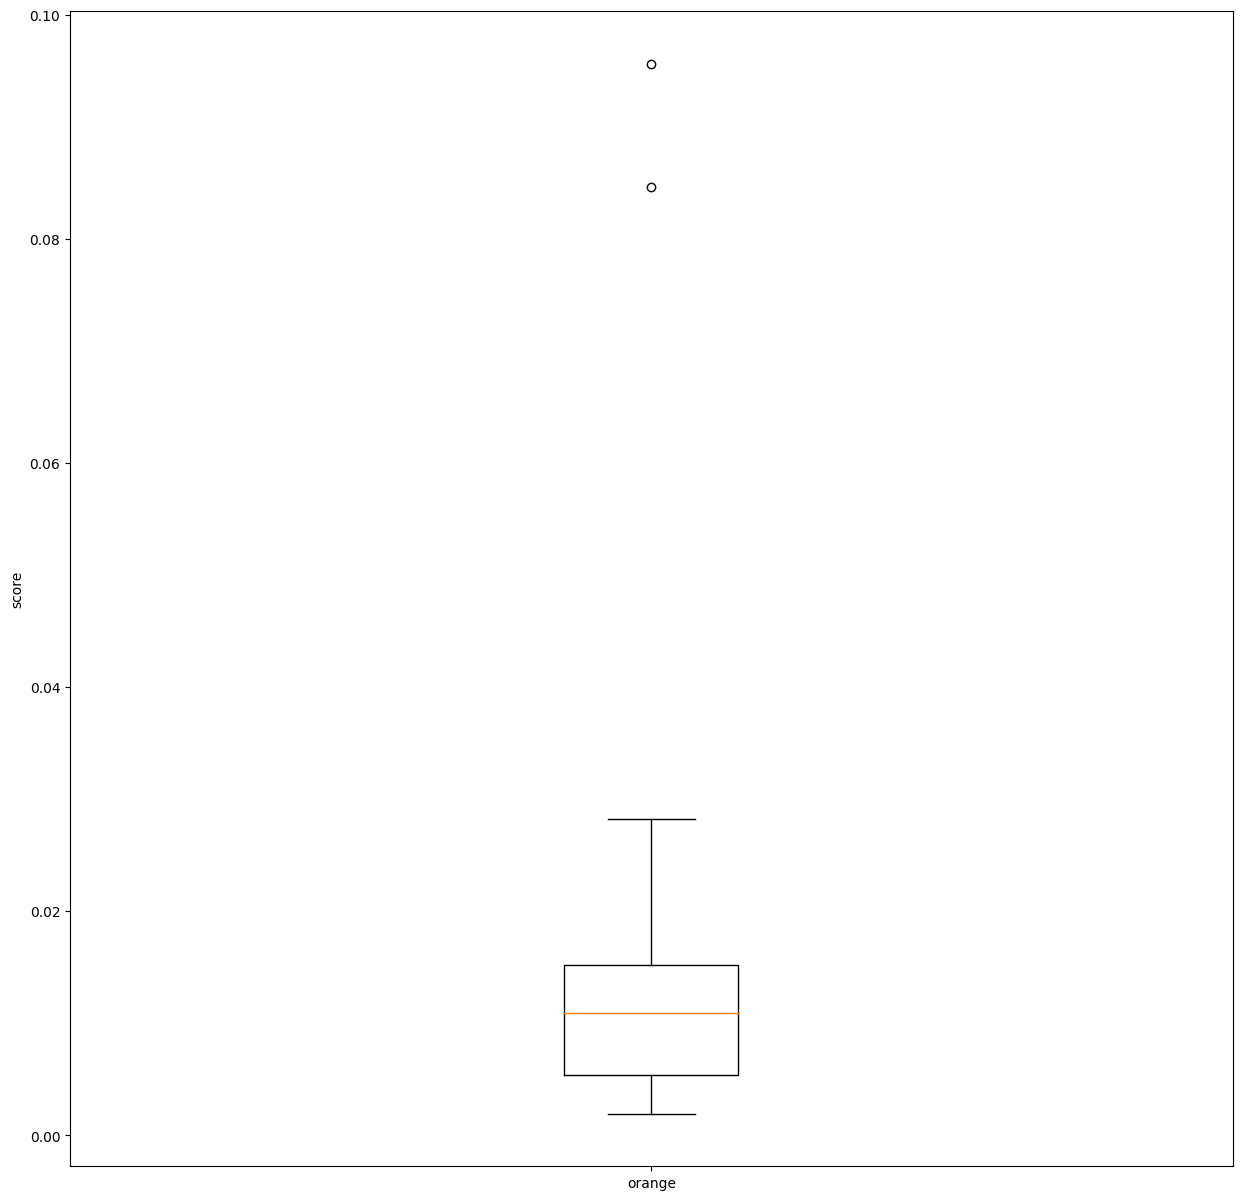

In [28]:
# test
plt.figure(figsize=(15, 15))
plt.boxplot([train_results[obj]['pr_sp'] for obj in obj_list])
plt.xticks([1], obj_list)
plt.ylabel('score')
plt.show()

##### (2) qhat

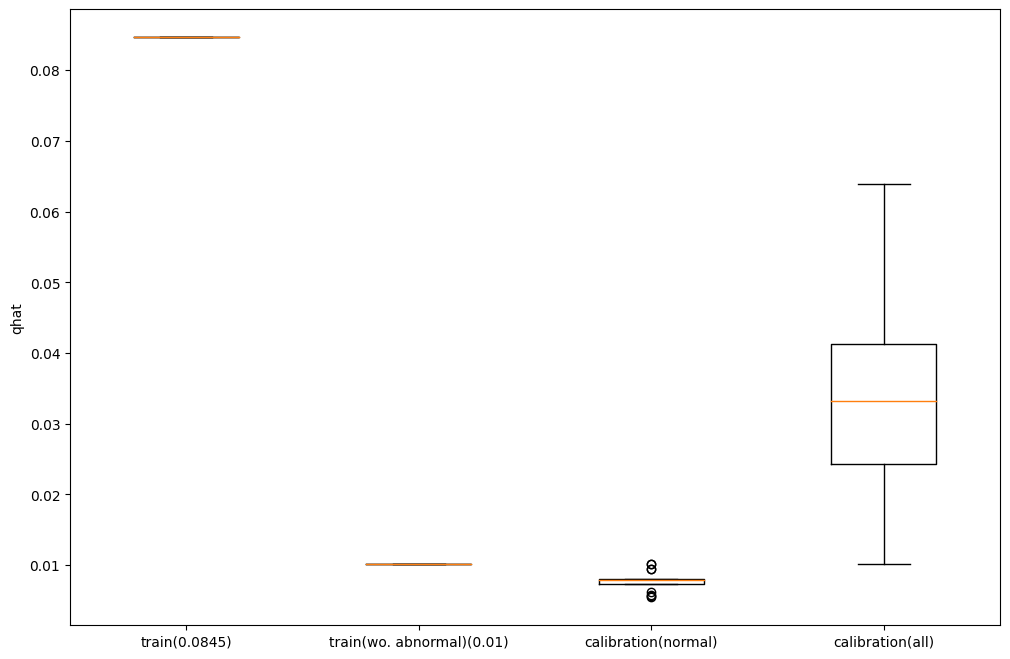

In [30]:
plt.figure(figsize=(12, 8))
plt.boxplot([train_qhat, train_qhat_wo_n, normal_all_qhat,  all_all_qhat])
plt.xticks([1, 2, 3, 4 ], ['train(0.0845)',  'train(wo. abnormal)(0.01)', 'calibration(normal)', 'calibration(all)'])
plt.ylabel('qhat')
plt.show()